In this experiment, we demonstrate that the effect of training a CNN with one layer, initialized by PCA coefficients, on pairs of CQT images, whether or not they are similar or non-similar. In the experiment, we used the PCA coefficients trained on original HashPrint approach's dataset. The annotation dataset is used for training to distinguish similar pairs and non-similar pairs. 

In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-Batchnorm]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = True      # Set to True if you want to see the loss function per epoch in real time

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer, BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='[{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-04-09 12:36:30,147 - root - DEBUG - Keras backend is tensorflow.
2018-04-09 12:36:30,148 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 20, 121)`.

In [5]:
logger.debug("Load Paired-annotation data")
# data = annotations.get_ref_query_pairs("taylorswift", beat_width=5900)
data = data_dict()["taylorswift"]
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))

songPairs = []
totalPairs = 0 
for ref, query in data:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair[:,:,28:48,:]) 
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-04-09 12:36:30,256 - root - DEBUG - Load Paired-annotation data
2018-04-09 12:36:30,257 - root - DEBUG - 	 data.type = <class 'generator'>
2018-04-09 12:36:30,258 - root - DEBUG - 	 data = <generator object get_ref_query_pairs at 0x7f2bea298258>
2018-04-09 12:36:44,871 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 20, 121)
2018-04-09 12:36:44,872 - root - DEBUG - Number of samples for the current song: 272
2018-04-09 12:36:58,680 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 20, 121)
2018-04-09 12:36:58,681 - root - DEBUG - Number of samples for the current song: 264
2018-04-09 12:37:03,858 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 20, 121)
2018-04-09 12:37:03,858 - root - DEBUG - Number of samples for the current song: 100
2018-04-09 12:37:09,118 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 20, 121)
2018-04-09 12:37:09,119 - root - DEBUG - Number of samples for the current song: 100
2018-

In [6]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-04-09 12:41:10,872 - root - DEBUG - Finish loading paired-annotation data
2018-04-09 12:41:10,873 - root - DEBUG - => There are 14 songs for training [63.52 percent]
2018-04-09 12:41:10,874 - root - DEBUG - => There are 6 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [7]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [8]:
X1, X2, S, W, groundTruth = generate_training_data(data_train, nNonSimilar=4000)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val, nNonSimilar=2000)

2018-04-09 12:41:11,381 - root - DEBUG - X1 shape: (7237, 1, 20, 121)
2018-04-09 12:41:11,382 - root - DEBUG - X2 shape: (7237, 1, 20, 121)
2018-04-09 12:41:11,382 - root - DEBUG - S shape: (7237, 1)
2018-04-09 12:41:11,383 - root - DEBUG - W shape: (7237, 1)
2018-04-09 12:41:11,384 - root - DEBUG - There are 3237 out of 7237 pairs that are similar [44.73 percent]
2018-04-09 12:41:11,560 - root - DEBUG - X1 shape: (3859, 1, 20, 121)
2018-04-09 12:41:11,561 - root - DEBUG - X2 shape: (3859, 1, 20, 121)
2018-04-09 12:41:11,562 - root - DEBUG - S shape: (3859, 1)
2018-04-09 12:41:11,563 - root - DEBUG - W shape: (3859, 1)
2018-04-09 12:41:11,563 - root - DEBUG - There are 1859 out of 3859 pairs that are similar [48.17 percent]


In [9]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [693]:
width = 20
height = 121
n_channel = 1

In [723]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [724]:
model_path = 'model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-04-10 12:32:36,247 - root - DEBUG - Load model from model.mat


In [725]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, (width, height), delta=delta, compute_delta=False)

### Remove this block of code if you want to have original hashprint model.

In [726]:
PCA_layer = base_model.layers[0]
PCA_layer.trainable = False
base_model.pop()
base_model.add(BatchNormalization(input_shape=(n_channel, width, height)))
base_model.add(Convolution2D(64, (20,1)))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(64, (1,3), padding='same'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(64, (1,3), padding='same'))

2018-04-10 12:32:37,042 - root - DEBUG - Save base_model architecture to base_model.png


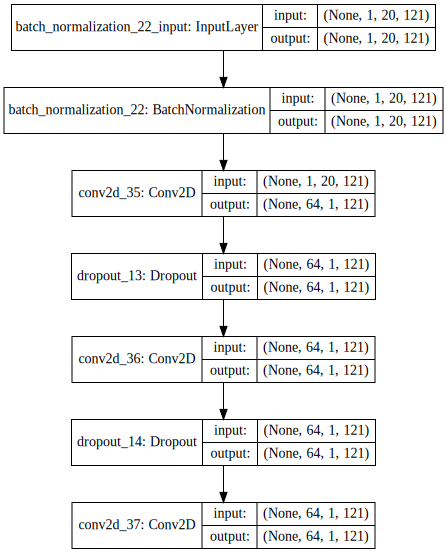

In [727]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [728]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [729]:
beta         = 1            # Initial beta value
numberOfBits = 64
alpha        = 0.01         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-04-10 12:32:38,437 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = 64, alpha = 0.01


In [730]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [731]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [732]:
hash_layer = Dense(numberOfBits, activation='tanh')
encoded_a = hash_layer(flatten_a)
encoded_b = hash_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [733]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-04-10 12:32:41,284 - root - DEBUG - Tensor("customized_loss_layer_12/Sum:0", shape=(?, 1), dtype=float32)


In [734]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [735]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-2")
adam = Adam(lr=1e-2, decay=1e-2)
model.compile(optimizer=adam, loss=zero_loss)

2018-04-10 12:32:42,095 - root - DEBUG - Use Adam optimizer with lr = 1e-2


__Visualize model architecture__

2018-04-10 12:32:42,742 - root - DEBUG - Save model architecture to model.png


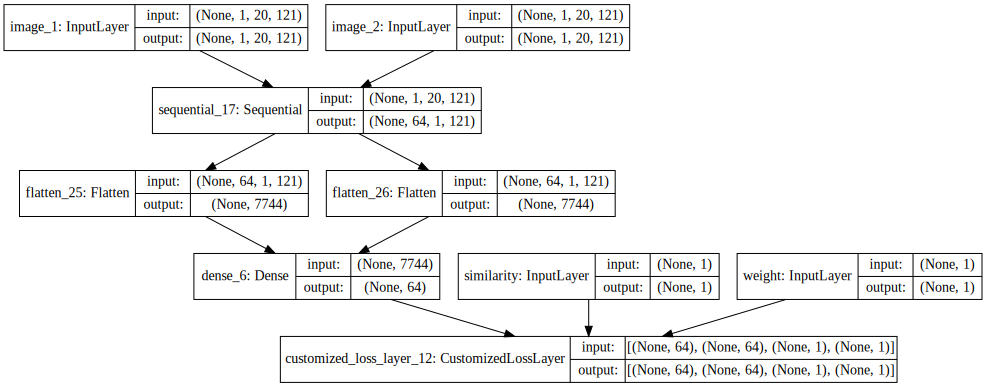

In [736]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [738]:
representation_model = Model(image_a, encoded_a)

In [739]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    bins = np.linspace(0, max(max(hist_sim), max(hist_non_sim)), 100)
    plt.ylim((0, 400))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

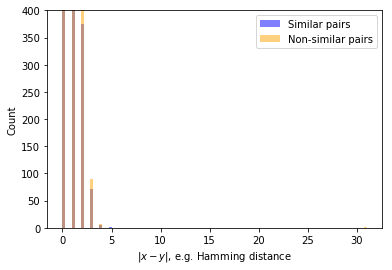

In [740]:
visualize(X1, X2, groundTruth, representation_model)

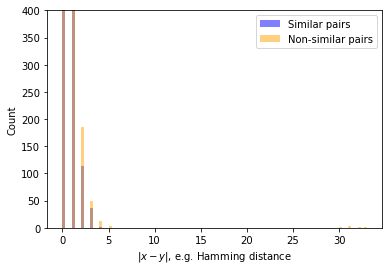

In [741]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [742]:
## Training Data

In [743]:
pred_X1 = (representation_model.predict(X1) > 0)
pred_X2 = (representation_model.predict(X2) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth[idx][0] == groundTruth[idx][1])
    if similarity:
        outputs_sim.append((score, X1[idx], X2[idx]))
    else:
        outputs_nonsim.append((score, X1[idx], X2[idx]))

In [744]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

Text(0.5,0.98,'Similar pairs from training data that are most similar')

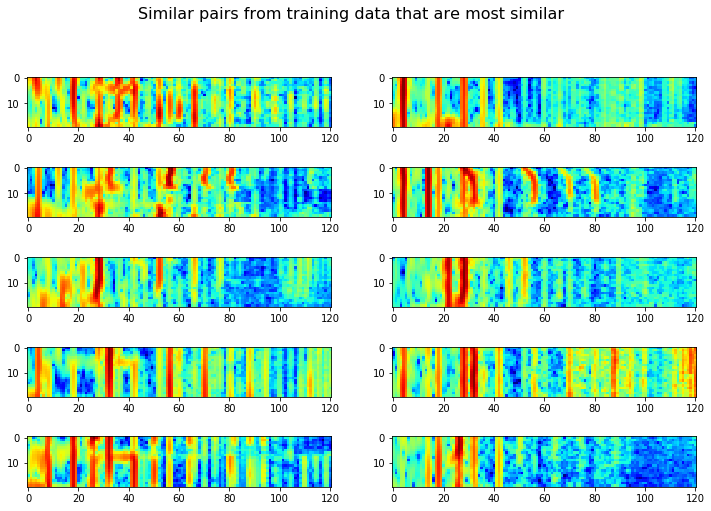

In [745]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from training data that are most similar", fontsize=16)

Text(0.5,0.98,'Similar pairs from training data that are least similar')

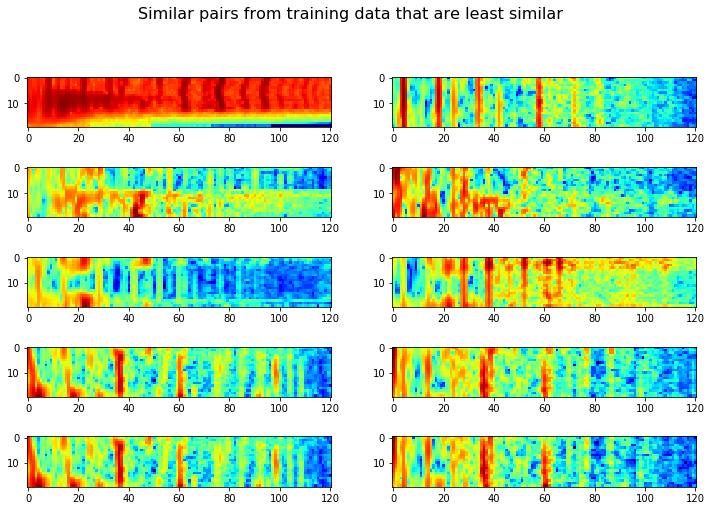

In [746]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from training data that are least similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from training data that are most similar')

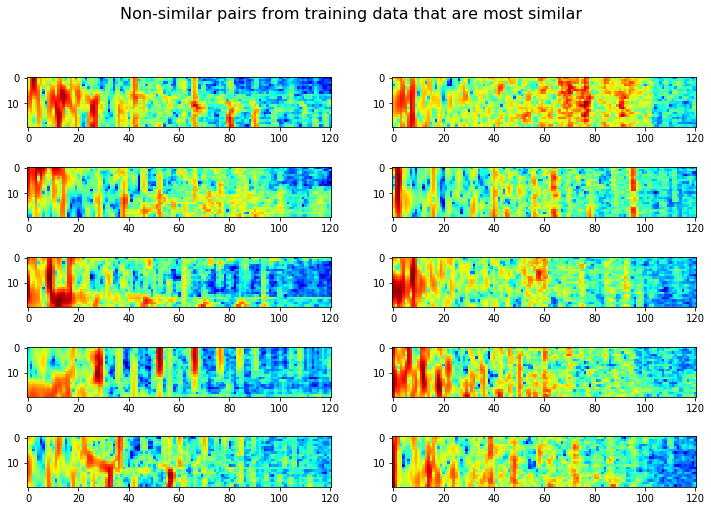

In [747]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from training data that are most similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from training data that are least similar')

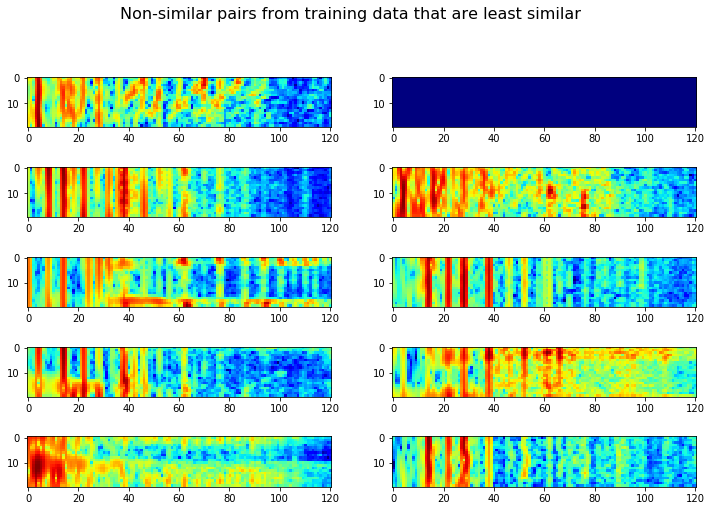

In [748]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Non-similar pairs from training data that are least similar", fontsize=16)

In [749]:
## Validation Data

In [750]:
pred_X1 = (representation_model.predict(X1_val) > 0)
pred_X2 = (representation_model.predict(X2_val) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth_val[idx][0] == groundTruth_val[idx][1])
    if similarity:
        outputs_sim.append((score, X1_val[idx], X2_val[idx]))
    else:
        outputs_nonsim.append((score, X1_val[idx], X2_val[idx]))

In [751]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

Text(0.5,0.98,'Similar pairs from validation data that are most similar')

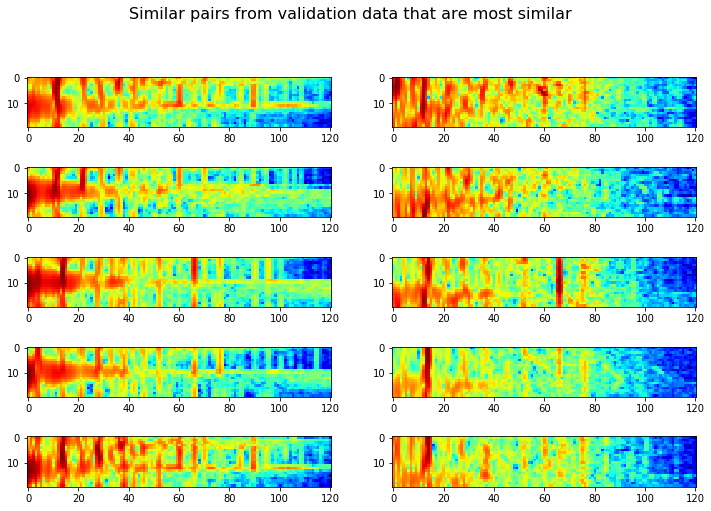

In [752]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from validation data that are most similar", fontsize=16)

Text(0.5,0.98,'Similar pairs from validation data that are least similar')

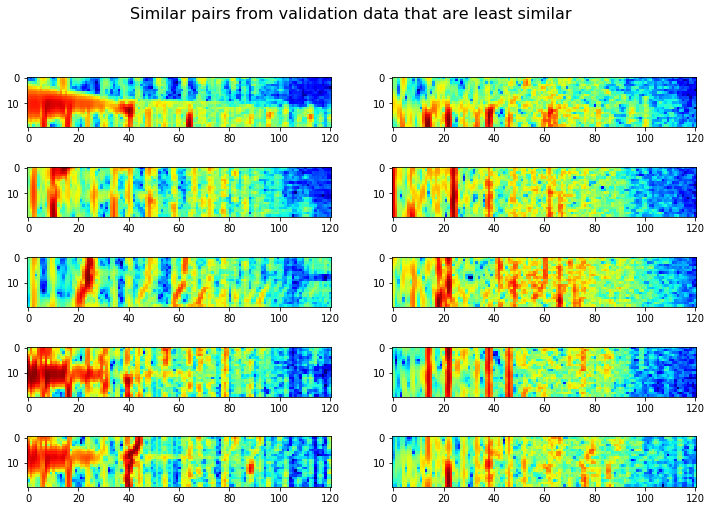

In [753]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from validation data that are least similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from validation data that are most similar')

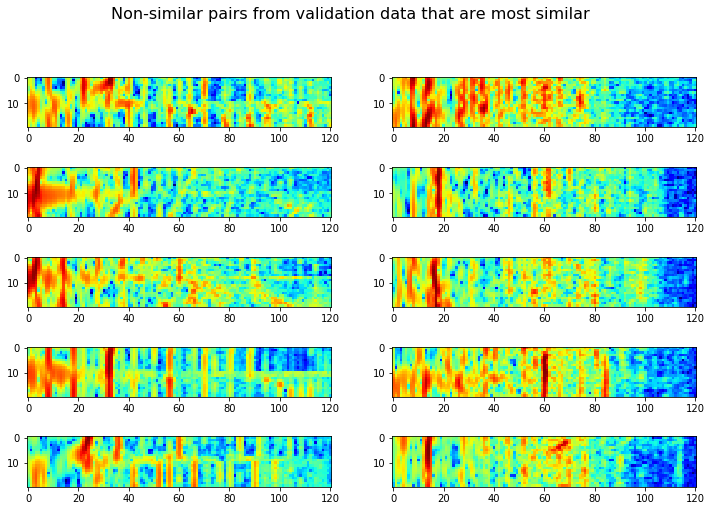

In [754]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are most similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from validation data that are least similar')

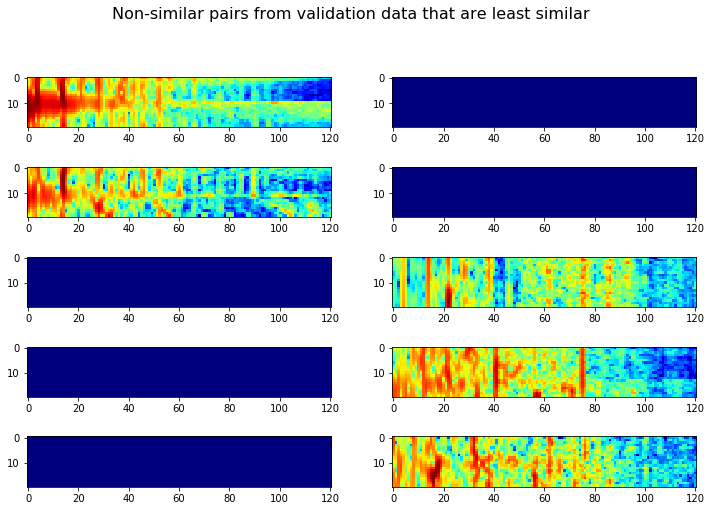

In [755]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are least similar", fontsize=16)    

## Train a model

In [756]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-04-10 12:33:24,374 - root - DEBUG - Ready to train the model
2018-04-10 12:33:24,376 - root - DEBUG - X1 shape: (7237, 1, 20, 121)
2018-04-10 12:33:24,377 - root - DEBUG - X2 shape: (7237, 1, 20, 121)
2018-04-10 12:33:24,378 - root - DEBUG - S shape: (7237, 1)
2018-04-10 12:33:24,379 - root - DEBUG - W shape: (7237, 1)


In [785]:
number_of_iterations = 100
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta = 1
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 100
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-04-10 12:42:44,137 - root - DEBUG - [Training] number_of_iterations = 100
2018-04-10 12:42:44,139 - root - DEBUG - [Training] beta_factor = 1.5
2018-04-10 12:42:44,140 - root - DEBUG - [Training] number_of_epochs = 100


In [758]:
train_losses = []
test_losses = []
m = 0

2018-04-10 12:42:52,952 - root - DEBUG - Iteration 10 (current beta = 1)
Train on 7237 samples, validate on 3859 samples
Epoch 1/100
7237/7237 [==============================] - 2s 330us/step - loss: 42.4519 - val_loss: 42.7228
Epoch 2/100
7237/7237 [==============================] - 2s 324us/step - loss: 42.4294 - val_loss: 43.0356
Epoch 3/100
7237/7237 [==============================] - 2s 342us/step - loss: 42.4967 - val_loss: 42.8628
Epoch 4/100
7237/7237 [==============================] - 2s 335us/step - loss: 42.4301 - val_loss: 42.8821
Epoch 5/100
7237/7237 [==============================] - 2s 336us/step - loss: 42.4572 - val_loss: 42.7138
Epoch 6/100
7237/7237 [==============================] - 2s 338us/step - loss: 42.5038 - val_loss: 42.6908
Epoch 7/100
7237/7237 [==============================] - 2s 340us/step - loss: 42.4183 - val_loss: 42.9174
Epoch 8/100
7237/7237 [==============================] - 2s 338us/step - loss: 42.4185 - val_loss: 42.8853
Epoch 9/100
7237/7237 [

Epoch 76/100
7237/7237 [==============================] - 2s 318us/step - loss: 42.3773 - val_loss: 42.6189
Epoch 77/100
7237/7237 [==============================] - 2s 337us/step - loss: 42.4068 - val_loss: 42.9460
Epoch 78/100
7237/7237 [==============================] - 2s 343us/step - loss: 42.4213 - val_loss: 42.9507
Epoch 79/100
7237/7237 [==============================] - 2s 340us/step - loss: 42.4063 - val_loss: 42.9464
Epoch 80/100
7237/7237 [==============================] - 2s 339us/step - loss: 42.3837 - val_loss: 42.9632
Epoch 81/100
7237/7237 [==============================] - 2s 341us/step - loss: 42.3698 - val_loss: 42.5917
Epoch 82/100
7237/7237 [==============================] - 2s 339us/step - loss: 42.3537 - val_loss: 42.5219
Epoch 83/100
7237/7237 [==============================] - 2s 333us/step - loss: 42.4255 - val_loss: 43.1276
Epoch 84/100
7237/7237 [==============================] - 2s 342us/step - loss: 42.4007 - val_loss: 42.6087
Epoch 85/100
7237/7237 [====

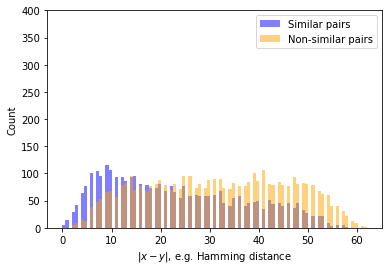

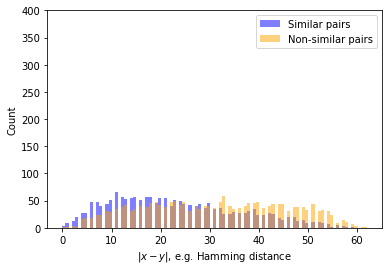

3859/3859 [==============================] - 0s 119us/step
2018-04-10 12:46:58,132 - root - DEBUG - [Iteration = 11] Training Loss = 42.41385813828116, Testing Loss = 42.57706647241755
2018-04-10 12:46:58,133 - root - DEBUG - Iteration 11 (current beta = 1.5)
Train on 7237 samples, validate on 3859 samples
Epoch 1/100
7237/7237 [==============================] - 2s 342us/step - loss: 42.3674 - val_loss: 42.4456
Epoch 2/100
7237/7237 [==============================] - 3s 346us/step - loss: 42.3439 - val_loss: 43.0408
Epoch 3/100
7237/7237 [==============================] - 3s 346us/step - loss: 42.3721 - val_loss: 43.0406
Epoch 4/100
7237/7237 [==============================] - 2s 344us/step - loss: 42.3470 - val_loss: 43.1642
Epoch 5/100
7237/7237 [==============================] - 2s 345us/step - loss: 42.3363 - val_loss: 42.5761
Epoch 6/100
7237/7237 [==============================] - 3s 346us/step - loss: 42.3923 - val_loss: 43.0231
Epoch 7/100
7237/7237 [===========================

7237/7237 [==============================] - 2s 345us/step - loss: 42.2927 - val_loss: 42.9817
Epoch 74/100
7237/7237 [==============================] - 3s 350us/step - loss: 42.3405 - val_loss: 42.9526
Epoch 75/100
7237/7237 [==============================] - 3s 346us/step - loss: 42.3267 - val_loss: 42.9558
Epoch 76/100
7237/7237 [==============================] - 2s 343us/step - loss: 42.3761 - val_loss: 42.9429
Epoch 77/100
7237/7237 [==============================] - 3s 348us/step - loss: 42.3218 - val_loss: 42.9477
Epoch 78/100
7237/7237 [==============================] - 2s 345us/step - loss: 42.3445 - val_loss: 42.5896
Epoch 79/100
7237/7237 [==============================] - 3s 346us/step - loss: 42.2336 - val_loss: 42.5846
Epoch 80/100
7237/7237 [==============================] - 3s 346us/step - loss: 42.2842 - val_loss: 42.5749
Epoch 81/100
7237/7237 [==============================] - 2s 345us/step - loss: 42.2890 - val_loss: 42.9536
Epoch 82/100
7237/7237 [=================

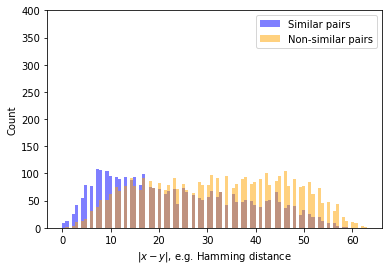

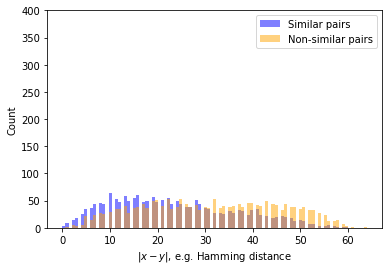

3859/3859 [==============================] - 0s 115us/step
2018-04-10 12:51:07,637 - root - DEBUG - [Iteration = 12] Training Loss = 42.452316382288096, Testing Loss = 42.576000335705224
2018-04-10 12:51:07,638 - root - DEBUG - Iteration 12 (current beta = 2.25)
Train on 7237 samples, validate on 3859 samples
Epoch 1/100
7237/7237 [==============================] - 2s 343us/step - loss: 42.3408 - val_loss: 42.5690
Epoch 2/100
7237/7237 [==============================] - 2s 340us/step - loss: 42.2518 - val_loss: 42.9544
Epoch 3/100
7237/7237 [==============================] - 3s 349us/step - loss: 42.2898 - val_loss: 42.9331
Epoch 4/100
7237/7237 [==============================] - 3s 354us/step - loss: 42.3869 - val_loss: 42.5736
Epoch 5/100
7237/7237 [==============================] - 2s 340us/step - loss: 42.3550 - val_loss: 42.5737
Epoch 6/100
7237/7237 [==============================] - 2s 342us/step - loss: 42.3192 - val_loss: 42.5758
Epoch 7/100
7237/7237 [========================

7237/7237 [==============================] - 2s 336us/step - loss: 42.2778 - val_loss: 42.5230
Epoch 74/100
7237/7237 [==============================] - 2s 340us/step - loss: 42.2857 - val_loss: 43.1229
Epoch 75/100
7237/7237 [==============================] - 2s 343us/step - loss: 42.2999 - val_loss: 42.9973
Epoch 76/100
7237/7237 [==============================] - 2s 341us/step - loss: 42.2589 - val_loss: 42.5121
Epoch 77/100
7237/7237 [==============================] - 2s 341us/step - loss: 42.2434 - val_loss: 42.5139
Epoch 78/100
7237/7237 [==============================] - 2s 339us/step - loss: 42.2841 - val_loss: 42.9824
Epoch 79/100
7237/7237 [==============================] - 2s 339us/step - loss: 42.2878 - val_loss: 42.9630
Epoch 80/100
7237/7237 [==============================] - 2s 340us/step - loss: 42.2717 - val_loss: 42.9837
Epoch 81/100
7237/7237 [==============================] - 2s 332us/step - loss: 42.2684 - val_loss: 42.5133
Epoch 82/100
7237/7237 [=================

In [ ]:
for i in range(number_of_iterations):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    m += 1

    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], 
              validation_data=({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val]),
              verbose=verbose, 
              epochs=number_of_epochs)
    beta *= beta_factor

    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)

    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

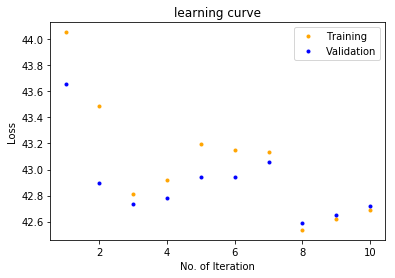

In [760]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

## Save Model

In [761]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(m)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-04-10 12:42:03,510 - root - DEBUG - Save model to 2018-04-10[HashNet-Batchnorm][Iteration=10].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [762]:
representation_model = Model(image_a, encoded_a)

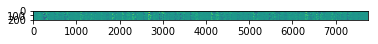

In [763]:
# Get sample output
test_model = Model(image_a, flatten_a)
pred_X1 = test_model.predict(X1)
pred_X2 = test_model.predict(X2)
plt.imshow(pred_X1[:200])
plt.show()

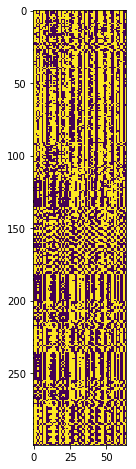

In [764]:
# Visualize the representation before threshold.
test_model = Model(image_a, encoded_a)
pred_X1 = test_model.predict(X1)
pred_X2 = test_model.predict(X2)
plt.figure(figsize=(12,8))
plt.imshow(pred_X1[400:700])
plt.show()

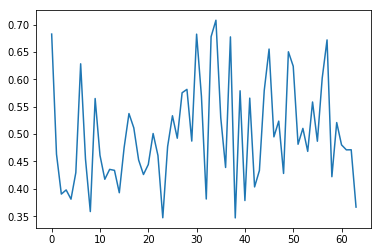

In [765]:
# Plot bit importance of X1
plt.plot(np.sum(pred_X1 > 0, axis=0) / len(pred_X1))

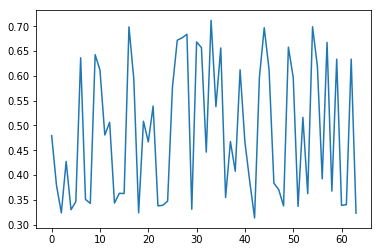

In [766]:
# Plot bit importance of X2
plt.plot(np.sum(pred_X2 > 0, axis=0) / len(pred_X2))

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

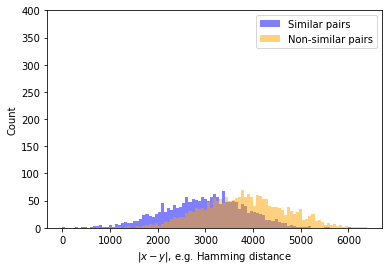

In [767]:
# Visualize the layer before Dense
representation_model = Model(image_a, flatten_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

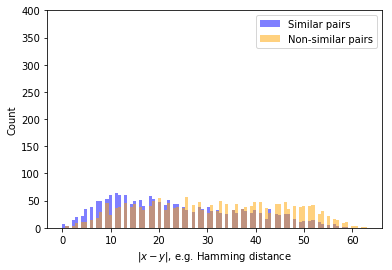

In [768]:
# Visualize the dense layer
representation_model = Model(image_a, encoded_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [769]:
## Training Data

In [770]:
pred_X1 = (representation_model.predict(X1) > 0)
pred_X2 = (representation_model.predict(X2) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth[idx][0] == groundTruth[idx][1])
    if similarity:
        outputs_sim.append((score, X1[idx], X2[idx]))
    else:
        outputs_nonsim.append((score, X1[idx], X2[idx]))

In [771]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

Text(0.5,0.98,'Similar pairs from training data that are most similar')

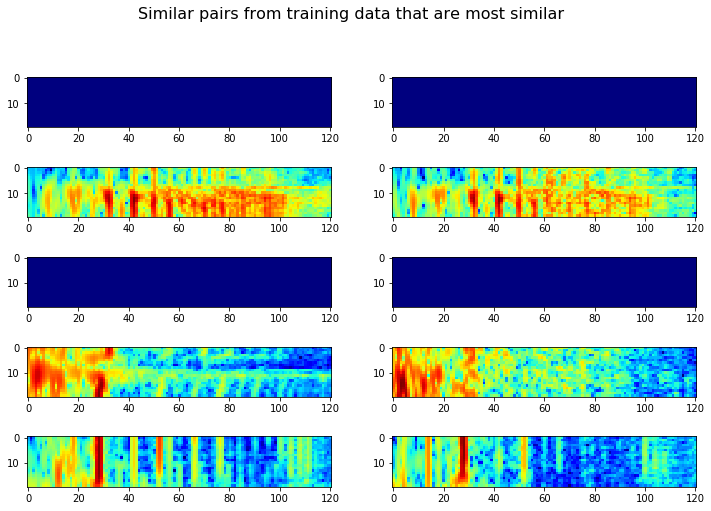

In [772]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from training data that are most similar", fontsize=16)

Text(0.5,0.98,'Similar pairs from training data that are least similar')

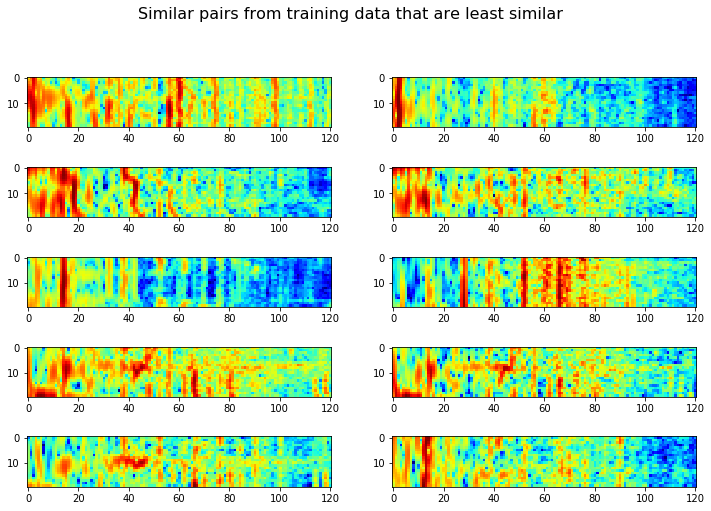

In [773]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from training data that are least similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from training data that are most similar')

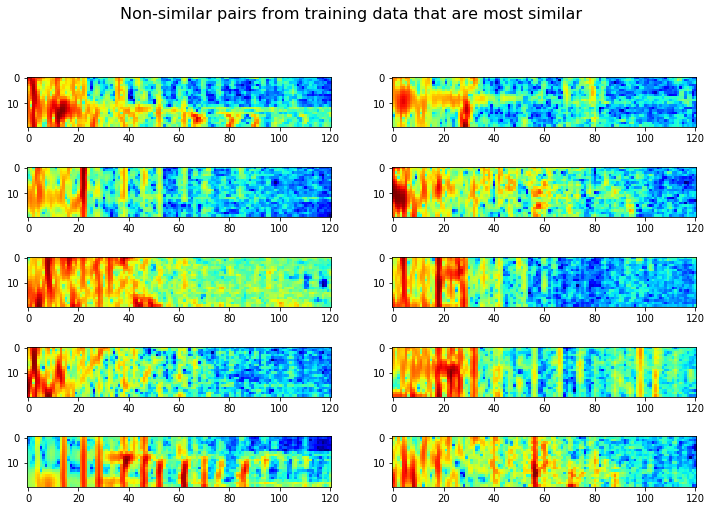

In [774]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from training data that are most similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from training data that are least similar')

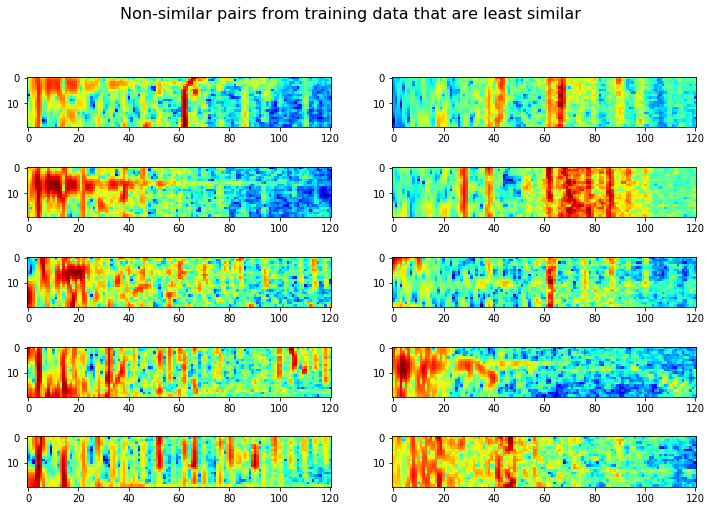

In [775]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Non-similar pairs from training data that are least similar", fontsize=16)

In [776]:
## Validation Data

In [777]:
pred_X1 = (representation_model.predict(X1_val) > 0)
pred_X2 = (representation_model.predict(X2_val) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth_val[idx][0] == groundTruth_val[idx][1])
    if similarity:
        outputs_sim.append((score, X1_val[idx], X2_val[idx]))
    else:
        outputs_nonsim.append((score, X1_val[idx], X2_val[idx]))

In [778]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

Text(0.5,0.98,'Similar pairs from validation data that are most similar')

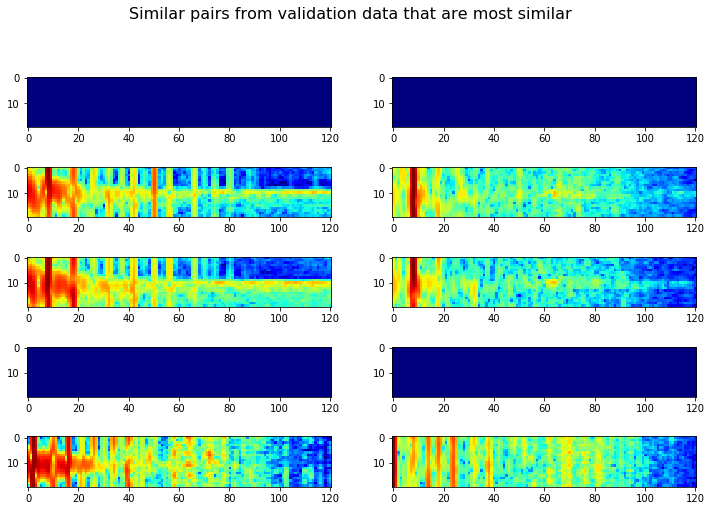

In [779]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from validation data that are most similar", fontsize=16)

In [780]:
outputs_sim[0]

(0, array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]), array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]))

Text(0.5,0.98,'Similar pairs from validation data that are least similar')

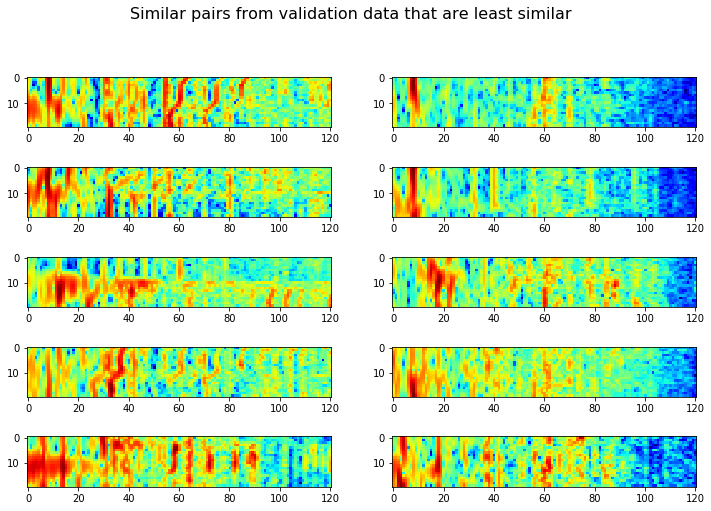

In [781]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from validation data that are least similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from validation data that are most similar')

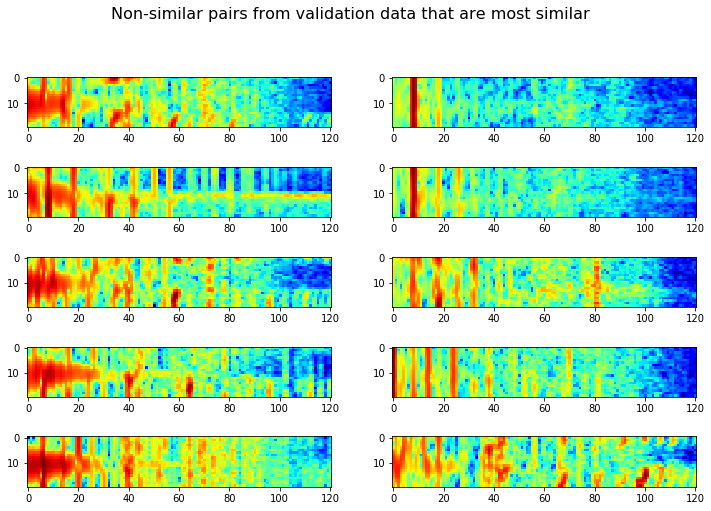

In [782]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are most similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from validation data that are least similar')

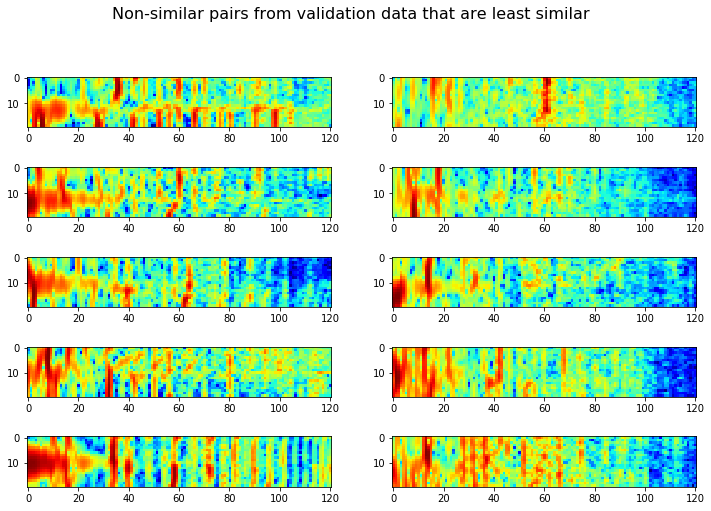

In [783]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are least similar", fontsize=16)    

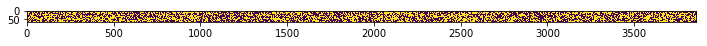

In [784]:
plt.figure(figsize=(12,8))
plt.imshow(representation_model.predict(X1_val).reshape(64,-1))

## Appendix: Architecture Details

In [452]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 1, 20, 121)        484       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 1, 1)          154880    
Total params: 155,364
Trainable params: 242
Non-trainable params: 155,122
_________________________________________________________________


# Evaluate for MRR

This evaluation is not similar to the original hashprint approach, as it truncates the query to be the same size as the size of `base_model.input_shape`.

In [551]:
import os
import h5py
from preprocess import get_allpaths
from search import calculateMRR

In [499]:
DATA_OUTPUT_DIR = "/data/mjenrungrot/live-song-output/" # Location to store *.npy files
AUDIO_DIR = "/home/mirlab/Data/SoftLinks/"              # Location of audio files input

In [503]:
ref_files = get_allpaths('taylorswift', os.path.join(AUDIO_DIR, 'Lists/'))

In [517]:
f = open(os.path.join(DATA_OUTPUT_DIR, 'taylorswift_cqtList.txt'), 'w')
for ref_file in ref_files:
    logger.debug("Process {:}".format(ref_file))
    audio_file = os.path.join(AUDIO_DIR, ref_file + '.wav')
    y, sr = librosa.load(audio_file)
    Q = librosa.cqt(y, sr=sr, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)
    
    # Preprocess CQT to logQ
    ds = 3
    absQ = np.absolute(Q)
    smoothQ = np.zeros((absQ.shape[0], absQ.shape[1]//ds))
    for row in range(absQ.shape[0]):
        smoothQ[row] = np.convolve(absQ[row], [1/ds]*ds, 'valid')[0:absQ.shape[1]-ds+1:ds]
    logQ = np.log(1+1000000*smoothQ)
    
    output_file = os.path.join(DATA_OUTPUT_DIR, ref_file + '.npy')
    np.save(output_file, logQ)
    f.write(ref_file + '.npy\n')
f.close()

2018-04-09 14:19:11,521 - root - DEBUG - Process taylorswift_ref1
2018-04-09 14:19:15,631 - root - DEBUG - Process taylorswift_ref2
2018-04-09 14:19:19,102 - root - DEBUG - Process taylorswift_ref3
2018-04-09 14:19:23,880 - root - DEBUG - Process taylorswift_ref4
2018-04-09 14:19:27,339 - root - DEBUG - Process taylorswift_ref5
2018-04-09 14:19:33,016 - root - DEBUG - Process taylorswift_ref6
2018-04-09 14:19:37,444 - root - DEBUG - Process taylorswift_ref7
2018-04-09 14:19:41,191 - root - DEBUG - Process taylorswift_ref8
2018-04-09 14:19:45,789 - root - DEBUG - Process taylorswift_ref9
2018-04-09 14:19:50,926 - root - DEBUG - Process taylorswift_ref10
2018-04-09 14:19:55,084 - root - DEBUG - Process taylorswift_ref11
2018-04-09 14:19:59,538 - root - DEBUG - Process taylorswift_ref12
2018-04-09 14:20:03,602 - root - DEBUG - Process taylorswift_ref13
2018-04-09 14:20:08,240 - root - DEBUG - Process taylorswift_ref14
2018-04-09 14:20:14,319 - root - DEBUG - Process taylorswift_ref15
2018

In [592]:
db_path = os.path.join(DATA_OUTPUT_DIR, "taylorswift_db.hdf5")
db = h5py.File(db_path, mode='w')
f = open(os.path.join(DATA_OUTPUT_DIR, 'taylorswift_cqtList.txt'), 'r')

In [591]:
db.close()
f.close()

In [593]:
def pitch_shift_CQT(M, shiftBins):
    """
        pitchshift equivalent of Prof Tsai's code in matlab
        M: a 2-D CQT matrix
        shiftBins: An integer that indicates the pitch to shift to
        return: a pitchshifted matrix
    """
    shifted = np.roll(M, shiftBins, axis=0)
    if shiftBins > 0:
        shifted[:shiftBins, :] = 0.
    else:
        shifted[shiftBins:, :] = 0.
    return shifted

In [594]:
for line in f:
    logger.debug('==> Generating database for %s' % os.path.basename(line)[:-1])
    full_path = os.path.join(DATA_OUTPUT_DIR, line[:-1])
    Q = np.load(full_path).T
    
    # Reshape
    width, height = Q.shape
    Q = Q[:(width - width%20)].reshape(-1, 1, 20, 121)
    
    pitch_shift_Qs = np.empty((9, ) + Q.shape)
    pitch_shift_Qs[0, :, :] = Q
    for i in range(1, 5):
        pitch_shift_Qs[i, :, :] = pitch_shift_CQT(Q.T, i).T
    for i in range(1, 5):
        pitch_shift_Qs[i + 4, :, :] = pitch_shift_CQT(Q.T, -i).T
    
    fpseqs = np.array([base_model.predict(pitch_shift_Qs[i]) for i in range(pitch_shift_Qs.shape[0])])

    key = os.path.basename(line)[:-1]
    fpseqs = fpseqs.reshape(9,-1,64)
    db.create_dataset(key, fpseqs.shape, np.bool)
    db[key][...] = np.where(fpseqs > 0, True, False)
f.close()
db.close()

2018-04-09 14:35:33,693 - root - DEBUG - ==> Generating database for taylorswift_ref1.npy
2018-04-09 14:35:34,323 - root - DEBUG - ==> Generating database for taylorswift_ref2.npy
2018-04-09 14:35:34,876 - root - DEBUG - ==> Generating database for taylorswift_ref3.npy
2018-04-09 14:35:35,646 - root - DEBUG - ==> Generating database for taylorswift_ref4.npy
2018-04-09 14:35:36,167 - root - DEBUG - ==> Generating database for taylorswift_ref5.npy
2018-04-09 14:35:37,030 - root - DEBUG - ==> Generating database for taylorswift_ref6.npy
2018-04-09 14:35:37,670 - root - DEBUG - ==> Generating database for taylorswift_ref7.npy
2018-04-09 14:35:38,239 - root - DEBUG - ==> Generating database for taylorswift_ref8.npy
2018-04-09 14:35:38,922 - root - DEBUG - ==> Generating database for taylorswift_ref9.npy
2018-04-09 14:35:39,723 - root - DEBUG - ==> Generating database for taylorswift_ref10.npy
2018-04-09 14:35:40,402 - root - DEBUG - ==> Generating database for taylorswift_ref11.npy
2018-04-

In [595]:
db_path = os.path.join(DATA_OUTPUT_DIR, 'taylorswift_db.hdf5')
db = h5py.File(db_path, mode='r')

In [596]:
query_paths = get_allpaths('taylorswift', os.path.join(AUDIO_DIR, 'Lists/'), file_type='query')

In [597]:
def get_query_shape():
    '''
        returns the shape of query file in (width, height)
    '''
    assert len(query_paths) > 0
    cur_file = query_paths[0]
    y, sr = librosa.load(AUDIO_DIR + cur_file + '.wav')
    Q = librosa.cqt(y, sr=sr, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)
    logQ = preprocess(Q, 3)
    return logQ.T.shape

In [598]:
query_shape = get_query_shape()
queries = np.empty((len(query_paths), ) + query_shape)

In [599]:
for i in range(len(query_paths)):
    cur_file = query_paths[i]
    print('==> Computing CQT of %s'%cur_file)
    y, sr = librosa.load(AUDIO_DIR + cur_file + '.wav')
    Q = librosa.cqt(y, sr=sr, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)
    logQ = preprocess(Q, 3)
    queries[i, :, :] = logQ.T

==> Computing CQT of taylorswift_query1
==> Computing CQT of taylorswift_query2
==> Computing CQT of taylorswift_query3
==> Computing CQT of taylorswift_query4
==> Computing CQT of taylorswift_query5
==> Computing CQT of taylorswift_query6
==> Computing CQT of taylorswift_query7
==> Computing CQT of taylorswift_query8
==> Computing CQT of taylorswift_query9
==> Computing CQT of taylorswift_query10
==> Computing CQT of taylorswift_query11
==> Computing CQT of taylorswift_query12
==> Computing CQT of taylorswift_query13
==> Computing CQT of taylorswift_query14
==> Computing CQT of taylorswift_query15
==> Computing CQT of taylorswift_query16
==> Computing CQT of taylorswift_query17
==> Computing CQT of taylorswift_query18
==> Computing CQT of taylorswift_query19
==> Computing CQT of taylorswift_query20
==> Computing CQT of taylorswift_query21
==> Computing CQT of taylorswift_query22
==> Computing CQT of taylorswift_query23
==> Computing CQT of taylorswift_query24
==> Computing CQT of tayl

In [609]:
q = []
for query in queries:
    width, height = query.shape
    query = query[:(width - width%20), :].reshape(-1, 1, 20, 121)
    output = np.where(representation_model.predict(query) > 0, True, False)
    q.append(output)

In [601]:
def get_querytoref(artist, listdir):
    '''
        artist: a string representing the artist
        listdir: a string representing the directory of the .list file
        returns an array of integer, where each entry corresponds to the
            reference index
    '''

    ref_idxs = []
    f = open(listdir+artist+'_querytoref.list', 'r')
    for line in f:
        ref_idx = (line.split(' '))[1]
        ref_idxs.append(int(ref_idx))
    f.close()
    return ref_idxs

In [602]:
refs = list(db.values())
ground_truths = get_querytoref('taylorswift', os.path.join(AUDIO_DIR, 'Lists/'))

In [603]:
mrr = calculateMRR(q, refs, ground_truths)

==> Searching query 0
	-- Time elapsed: 0 seconds
==> Searching query 1
	-- Time elapsed: 0 seconds
==> Searching query 2
	-- Time elapsed: 0 seconds
==> Searching query 3
	-- Time elapsed: 0 seconds
==> Searching query 4
	-- Time elapsed: 0 seconds
==> Searching query 5
	-- Time elapsed: 0 seconds
==> Searching query 6
	-- Time elapsed: 0 seconds
==> Searching query 7
	-- Time elapsed: 0 seconds
==> Searching query 8
	-- Time elapsed: 0 seconds
==> Searching query 9
	-- Time elapsed: 0 seconds
==> Searching query 10
	-- Time elapsed: 0 seconds
==> Searching query 11
	-- Time elapsed: 0 seconds
==> Searching query 12
	-- Time elapsed: 0 seconds
==> Searching query 13
	-- Time elapsed: 0 seconds
==> Searching query 14
	-- Time elapsed: 0 seconds
==> Searching query 15
	-- Time elapsed: 0 seconds
==> Searching query 16
	-- Time elapsed: 0 seconds
==> Searching query 17
	-- Time elapsed: 0 seconds
==> Searching query 18
	-- Time elapsed: 0 seconds
==> Searching query 19
	-- Time elapsed: 

In [605]:
mrr

0.12857667351910795

In [606]:
q[0].shape

(22, 64)